<a href="https://colab.research.google.com/github/ParthikB/Neural-Style-Transfer/blob/v0.1/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# enable eager execution

# visualize and load images

# define what layers to take activations out from

# define --> load VGG --> get style and content modelOutputs --> add both of them --> return the sum modelOutput

# implement gram matrix and other loss functions

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import tensorflow as tf
import keras.backend as K
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.models import Model
from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
import time

In [68]:
# Resetting any graph if initialized
tf.reset_default_graph()

# Enabling Eager Execution
tf.enable_eager_execution()
print("Eager Execution Initialized:",tf.executing_eagerly())

Eager Execution Initialized: True


### Visualizing Images

In [0]:
contentImagePath = '/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/images/content1.jpg'
styleImagePath   = '/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/images/style1.jpg'

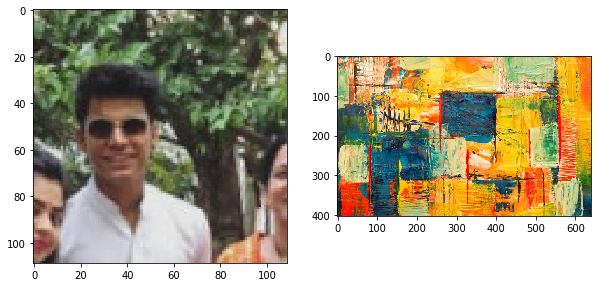

In [70]:
content = plt.imread(contentImagePath)
style   = plt.imread(styleImagePath)

plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(content)

plt.subplot(1, 2, 2)
plt.imshow(style)

### Selecting the Feature Layers needed

In [0]:
contentLayer = ['block4_conv1']

styleLayers  = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1',]

numContentLayers = len(contentLayer)
numStyleLayers   = len(styleLayers)

In [0]:
def getModel():

  model = VGG19(weights='imagenet', include_top=False)
  model.trainable = False

  contentFeatures = [model.get_layer(name) for name in contentLayer]
  styleFeatures   = [model.get_layer(name) for name in styleLayers]

  modelOutput = contentFeatures + styleFeatures

  return Model(model.input, modelOutput)

In [0]:
# Defining GRAM MATRIX
def gram(x):
  # number of channels
  channels = int(x.shape[-1])
  
  # reshaping to channel first
  x = tf.reshape(x, [-1, channels])
  n = tf.shape(x)[0]
  
  # gram matrix
  gram = tf.matmul(x, tf.transpose(x))

  return gram / tf.cast(n, tf.float32)


# Defining CONTENT COST
def contentCost(contentFeatures, generateFeatures):
  return tf.reduce_mean(tf.square(contentFeatures-generateFeatures))


# Defining STYLE COST
def styleCost(styleFeatures, generateFeatures):
  styleGram = gram(styleFeatures)
  return tf.reduce_mean(tf.square(styleGram - generateFeatures))

In [0]:
"""
  Helper function to compute our content and style feature representations.
 
  This function will simply load and preprocess both the content and style 
  images from their path. Then it will feed them through the network to obtain
  the outputs of the intermediate layers. 
  
  Arguments:
    model: The model that we are using.
    content_path: The path to the content image.
    style_path: The path to the style image
    
  Returns:
    returns the style features and the content features. 
  """
def inputImageAndPreprocess(path):
  # Loading the image and reshaping it according to VGG19 requirements.
  img = image.load_img(path, target_size=(224, 224, 3))
  
  # Converting the image tensor into numpy array
  imgArr = image.img_to_array(img)

  # Expanding to the 4th dimension
  imgArr = np.expand_dims(imgArr, axis=0)
  
  # Preprocessing the img according to VGG19 requirements
  imgArr = preprocess_input(imgArr)

  return img, imgArr


def getFeatures(contentPath, stylePath, model):
  
  # Loading and pre-processing the images
  contentShow, content = inputImageAndPreprocess(contentPath)
  styleShow, style     = inputImageAndPreprocess(stylePath)

  # Concatenating the images to input to the model and getting the features
  stackImages = np.concatenate([style, content], axis=0)
  features = model(stackImages)

  # Extracting out the different features from the model output
  contentFeatures = [contentFeature[1] for contentFeature in features[numStyleLayers:]]
  styleFeatures = [styleFeature[0] for styleFeature in features[:numStyleLayers]]

  return contentFeatures, styleFeatures


In [0]:
def totalLoss(model, lossWeights, generate, styleFeatures, contentFeatures):

  # Extracting the respective weights
  styleWeight, contentWeight, variationWeight = lossWeights

  # Extracting the generate image features from the model
  modelOutputs = model(generate)

  # Splitting the generate Features into different categories
  contentGenerateFeatures = modelOutputs[numStyleLayers:]
  styleGenerateFeatures   = modelOutputs[:numStyleLayers]

  # Initializing all costs with 0
  styleCost, contentCost = 0, 0

  # Defining partial weights
  styleWeightPerLayer = 1.0 / float(numStyleLayers)
  contentWeightPerLayer = 1.0 / float(numContentLayers)

  # Computing Content Cost
  for generateContent, combinationContent in zip(contentFeatures, contentGenerateFeatures):
    contentCost += contentWeightPerLayer * contentCost(combinationContent[0], generateContent)

  # Computing Style Cost for every layer
  for generateStyle, combinationStyle in zip(styleFeatures, styleGenerateFeatures):
    styleCost += styleWeightPerLayer * styleCost(combinationStyle[0], generateStyle)

  # Assigning the weights
  contentCost *= contentWeight
  styleCost *= styleWeight

  # Computing the Total Loss
  totalLoss = contentCost + styleCost

  return totalLoss, contentCost, styleCost

In [0]:
def computeGrads(config):
  with tf.GradientTape() as tape:
    allLoss = totalLoss(**config)

  totalLoss = allLoss[0]

  return tape.gradient(totalLoss, config['generate']), allLoss

In [77]:
"""
FUNTIONS DEFINED SO FAR:

  > getModel()
  > gram()
  > contentCost()
  > styleCost()
  > inputImageAndPreprocess()
  > getFeatures()
  > totalLoss()
  > computeGrads()

"""

"""
STEPS TO FOLLOW NOW:

1) Load model
2) Get Style and Content Features Representations
3) Set generated Image (as Content Image)
4) Create Optimizer
5) Create config
6) Start Iterations:
  > compute grads
  > Extract the different Losses
  > Apply Gradients to the optimizer (step 4)
  > 
"""

'\nSTEPS TO FOLLOW NOW:\n\n1) Load model\n2) Get Style and Content Features Representations\n3) Set generated Image (as Content Image)\n4) Create Optimizer\n5) Create config\n6) Start Iterations:\n  > compute grads\n  > Extract the different Losses\n  > Apply Gradients to the optimizer (step 4)\n  > \n'

In [0]:
def runStyleTransfer(contentPath,
                     stylePath,
                     iterations    = 1000,
                     contentWeight = 1e3,
                     styleWeight   = 1e-2):
  
  SAVE_EVERY = 1
  
  # Step 1
  model = getModel()
  for layer in model.layers:
    layer.trainable = False

  # Step 2
  contentFeatures, styleFeatures = getFeatures(contentPath, stylePath, model)
  styleFeatures = [gram(styleFeature) for styleFeature in styleFeatures]

  # Step 3
  generateImage = inputImageAndPreprocess(contentPath)
  generateImage = tf.Variable(generateImage, dtype=tf.float32)

  # Step 4
  optimizer = tf.train.AdamOptimizer(learning_rate=10)

  # Storing the best Image and Loss
  bestLoss, bestImage = float('inf'), None

  # Step 5
  lossWeights = (styleWeight, contentWeight)
  
  config = {
    'model': model,
    'lossWeights': lossWeights,
    'generateImage': generateImage,
    'styleFeatures': styleFeatures,
    'contentFeatures': contentFeatures
    }
  
  # Step 6    
  globalStart = time.time()
  
  normMeans = np.array([103.939, 116.779, 123.68])
  minVals = -normMeans
  maxVals = 255 - normMeans  

  for iter in range(iterations):

    startTime = time.time()

    grads, allLoss = computeGrads(config)

    totalLoss, styleLoss, contentLoss = allLoss

    optimizer.apply_gradients([(grads, generateImage)])

    clipped = tf.clip_by_value(generateImage, minVals, maxVals)
    generateImage.assign(clipped)

    endTime = time.time()

    if i % SAVE_EVERY == 0:
      PATH = f'/content/drive/My Drive/Colab Notebooks/Neural Style Transfer/images/output/generateImage_{i+1}.jpg'
      image.save_img(PATH, generateImage)
      timeTaken = endTime - startTime
      print(f"Image {i+1} Saved || Time Taken: {round(timeTaken, 2)}")


    if totalLoss < bestLoss:
      # Update best loss and best image from total loss. 
      bestLoss = totalLoss
      bestImage = generateImage.numpy()

    return bestImage, bestLoss 


In [79]:
runStyleTransfer(contentImagePath,
                 styleImagePath)

RuntimeError: ignored